# Importance sampling

## Recap

We have some target function (the likelihood times the prior) in some parameter space, and we want to integrate it.

As a toy example, we chose the following likelihood:

In [41]:
def loglikelihood(*parameters):
    a = np.asarray(parameters)[:-1] * 10
    b = np.asarray(parameters)[1:] * 10
    return -2 * (100 * (b - a**2)**2 + (1 - a)**2).sum()

And we assume our prior is uniform in the domain -1/2 to +1/2 in each parameter. 
We use two parameters at the moment.

In [44]:
lo = -0.5
hi = 0.5
dim = 2

Lets plot this function in 2d:

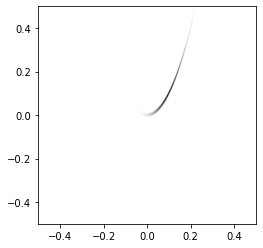

In [45]:
import numpy as np
import matplotlib.pyplot as plt

a = np.linspace(lo, hi, 400)
b = np.linspace(lo, hi, 400)

# TODO by you!

grid = np.meshgrid(a, b)
grid_unnormalised_logposterior = np.vectorize(loglikelihood)(grid[0], grid[1])

plt.imshow(
      np.exp(grid_unnormalised_logposterior[::-1]),
      extent=(lo, hi, lo, hi),
      aspect='equal', cmap='gray_r');

## Importance sampling intro

Instead of a uniform spaced grid, lets now use uniformly distributed points:

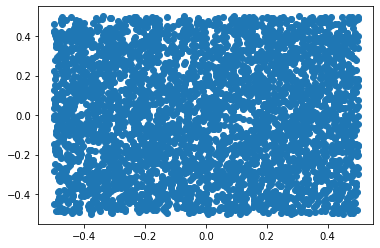

In [120]:
Ndraw = 4000

proposed_samples = np.random.uniform(lo, hi, size=(Ndraw, dim))

plt.scatter(proposed_samples[:,0], proposed_samples[:,1]);

If we evaluate the likelihood at each point:

In [104]:
proposed_samples_loglike = [loglikelihood(*sample) for sample in proposed_samples]

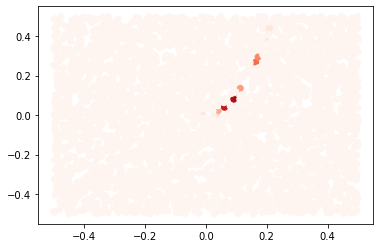

In [105]:
plt.scatter(proposed_samples[:,0], proposed_samples[:,1], c=np.exp(proposed_samples_loglike), cmap='Reds');

Monte Carlo integration tells us that

$Z=\int d\theta f(\theta) \approx \frac{1}{N} \sum_{i=1}^N f(\theta_i) $

The agreement is exact when $N\rightarrow \infty$.

In [106]:
Z = np.exp(proposed_samples_loglike).mean()

Z

0.001193124178176026

## Effective number of samples

Since most samples have zero weight, they do not contribute effectively to the integral.

We can compute the effective number of samples can be defined as:

$ESS = \frac{N}{1 + \frac{1}{N}\sum_i(N \times \frac{w_i}{\sum_i w_i} - 1}$


In [121]:
def effective_sample_size(importance_weights):
    return int(len(importance_weights) / (1 + (importance_weights / importance_weights.mean() - 1)**2).mean() )

'Effective number of samples: %d' % effective_sample_size(np.exp(proposed_samples_loglike))

'Effective number of samples: 9'

## Exercise 1

1a) Measure the variance in the integral estimate by running the method a few times.

1b) Vary the number of samples drawn. Plot variance vs number of samples.

1c) Compare to the variance expected: $Var(Z)=Var(f) / N_{draw}$



# Importance Sampling


* Most of the points had zero likelihood.

* To better use the evaluations, perhaps we can choose spacing that is biased to the likelihood peak?

Lets try a narrow Gaussian centered at (0.1, 0.1):

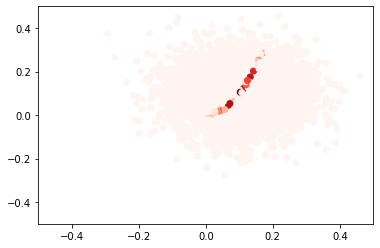

In [108]:
ctr = 0.1 + np.zeros(dim)
std = 0.1 + np.zeros(dim)

biased_proposed_samples = np.random.normal(ctr, std, size=(Ndraw, dim))
biased_proposed_samples_loglike = [loglikelihood(*sample) for sample in biased_proposed_samples]

plt.scatter(biased_proposed_samples[:,0], biased_proposed_samples[:,1], c=np.exp(biased_proposed_samples_loglike), cmap='Reds');
plt.xlim(lo, hi)
plt.ylim(lo, hi);

It looks like we are getting many more "hits" on high probability regions now.

But our proposal is biased. The bias is the probability density of our proposal function:

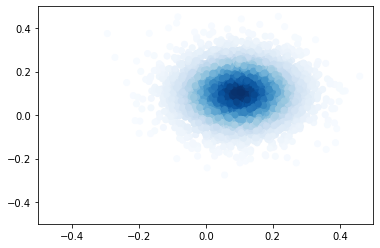

In [122]:
import scipy.stats

random_variable = scipy.stats.norm(ctr, std)
weight = [np.product(random_variable.pdf(biased_proposed_sample)) for biased_proposed_sample in biased_proposed_samples]

plt.scatter(biased_proposed_samples[:,0], biased_proposed_samples[:,1], c=weight, cmap='Blues');
plt.xlim(lo, hi)
plt.ylim(lo, hi);

Importance weighting is adjusting the weights in our sum from

$Z\approx \frac{1}{N} \sum_{i=1}^N f(\theta_i) $

to

$Z\approx \frac{1}{N} \sum_{i=1}^N f(\theta_i)/W(\theta_i) $

In words, we down-weight samples where the proposal had high probability.

In [110]:
importance = np.exp(biased_proposed_samples_loglike) / weight

Z = (importance).mean()

Z

0.001458235089040792

# Effective sample size

In [99]:
effective_sample_size(importance)

2396

# Posterior probability distributions

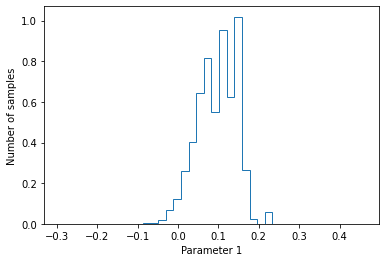

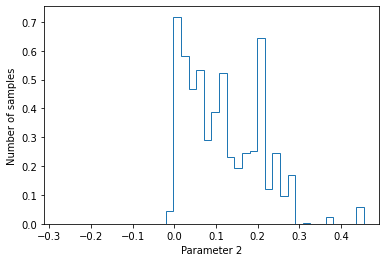

In [113]:
for i in range(dim):
    plt.figure()
    plt.xlabel("Parameter %d" % (i+1))
    plt.ylabel("Number of samples")
    plt.hist(biased_proposed_samples[:,i], weights=importance, bins=40, histtype='step')


## Unweighted posterior samples

In [123]:
# pick as many as there are effective samples
N_chosen = effective_sample_size(importance)
# pick them proportional to their weight
indices_chosen = np.random.choice(len(importance), p=importance / importance.sum(), size=N_chosen)
unweighted_posterior_samples = biased_proposed_samples[indices_chosen,:]

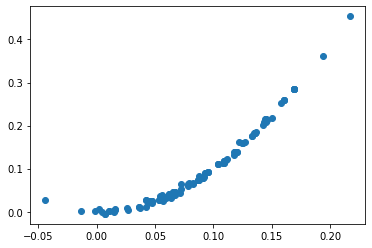

In [124]:
plt.scatter(unweighted_posterior_samples[:,0], unweighted_posterior_samples[:,1]);

## Questions:

* What would be the ideal proposal?

* If the proposal matched the target probability density, all sum terms would be a constant. What is that constant?

* We can already evaluate the target function, why can we not use it as a proposal?

## Quality of importance sampling

The variance of the Monte Carlo estimator of $Z$ is driven by the variance in the sum terms. Here for importance sampling:

$Var(Z)=Var(f / W) / N_{draw}$

The variance is smallest when $W \propto f$. 

We can quantify this by the variance in the sampled points:

In [125]:
'Standard deviation on Z for Uniform sampling: %.5f' % np.std(np.exp(proposed_samples_loglike))

'Standard deviation on Z for Uniform sampling: 0.02473'

In [126]:
'Standard deviation on Z for Importance sampling: %.5f' % np.std(np.exp(biased_proposed_samples_loglike) / weight)

'Standard deviation on Z for Importance sampling: 0.00845'

## Questions

* Which method is better?

* Is the variance part of the effective size samples formula?

## Exercise 2:

Find a 90% credible region from the importance sampling results. 

Hint: use the weighted posterior samples, respecting the weighting, or the resampled posterior sampled.

## Exercise 3:

Repeat exercise 1 with importance sampling.

## Homework Exercise 1:

Optimize the Gaussian proposal.

## Homework Exercise 2:

Vary the dimensionality of the problem. How does the variance scale with dimension?

## Further reading

Keywords:

* *Gaussian mixture models*: Useful for approximating complex target distributions
* *Variational Bayes*: A procedure for optimizing proposals
